## HW_4

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .
3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.
4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек. 
5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10*i-й до (i+1)*10 -й,... ,от 90 до 100-й точках (используйте осреденение по десяткам точек)

6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

### Ответы

#### -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.feature_selection import f_regression

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import itertools

import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])
data_w = data.resample('W').mean()

#### -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .

In [3]:
data_w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 866 entries, 2002-01-06 to 2018-08-05
Freq: W-SUN
Data columns (total 12 columns):
PJME_MW            866 non-null float64
year               866 non-null float64
month              866 non-null float64
dayofmonth         866 non-null float64
quarter            866 non-null float64
dayofyear          866 non-null float64
weekofyear         866 non-null float64
dayofweek          866 non-null float64
hour               866 non-null float64
is_holiday         866 non-null float64
is_prev_holiday    866 non-null float64
is_next_holiday    866 non-null float64
dtypes: float64(12)
memory usage: 88.0 KB


In [4]:
test_ADF = sm.tsa.stattools.adfuller(data_w['PJME_MW'].values, regression='ctt')
print(f'adf = {test_ADF[0]:.2f}' 
      f'\nкритическое значение при 1% ошибке = {test_ADF[4]["1%"]:.2f},'
      f'\np-value = {test_ADF[1]:.4f}')

adf = -13.62
критическое значение при 1% ошибке = -4.38,
p-value = 0.0000


Судя по показателям, ряд стационарный

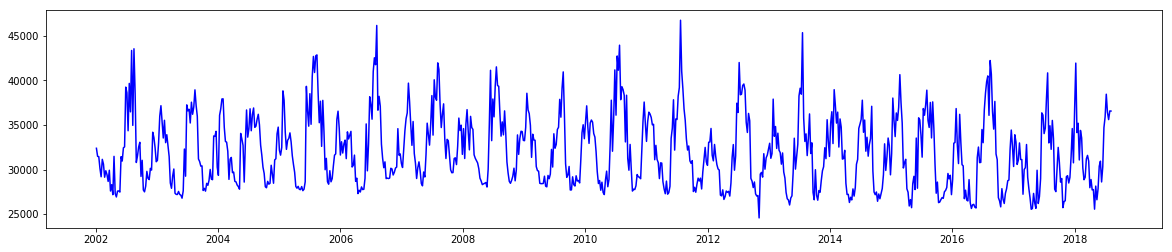

In [5]:
plt.figure(figsize =(20,4))
plt.plot(data_w.index, data_w['PJME_MW'], 'b')

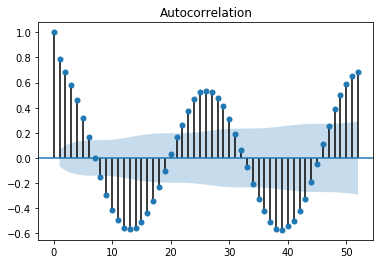

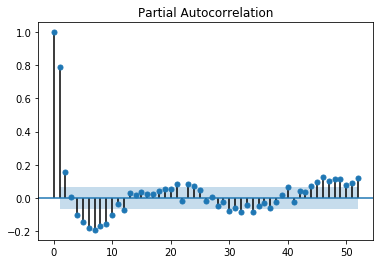

In [6]:
sm.graphics.tsa.plot_acf(data_w['PJME_MW'].values, lags=52)
sm.graphics.tsa.plot_pacf(data_w['PJME_MW'].values, lags=52)
plt.show()

__Достроим признаки__

1) Экспоненциальное сглаживание

In [7]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [8]:
for i in range(2, 10):
    data_w['exp_sm_'+str(i)] = exponential_smoothing(data_w['PJME_MW'], 0.01*i)

2) 1-ые разности, отнормированные на максимум

In [9]:
first_diff = data_w.iloc[1:, 0].values - data_w.iloc[:-1, 0].values

In [10]:
data_w['diff_1'] = 0.

In [11]:
data_w['diff_1'].values[1:] = first_diff

In [12]:
d_max = (np.abs(data_w['diff_1'])).max()

In [13]:
data_w['diff_n'] = data_w['diff_1']/d_max

3) Логарифм, тоже отнормированный на максимум

In [14]:
first_diff_log = np.log(data_w.iloc[1:, 0].values)

In [15]:
data_w['diff_log'] = 0.

In [16]:
data_w['diff_log'].values[1:] = first_diff_log

In [17]:
d_log_max = data_w['diff_log'].max()

In [18]:
data_w['diff_log_n'] = data_w['diff_log']/d_log_max

4) Скользящее среднее (месяц, квартал, полгода).

In [19]:
for i in (4, 13, 26):
    data_w['move_avr_'+str(i)] = data_w['PJME_MW'].rolling(window=i).mean()

In [20]:
for i in (4, 13, 26):
    data_w.loc[data_w['move_avr_'+str(i)].isnull(), 'move_avr_'+str(i)] = 0.

5) "Исторические" признаки на глубину p = 52

In [21]:
p = 52
for i in range(1, p):
    data_w['history_'+str(p-i)] = 0.
    data_w['history_'+str(p-i)].values[p:] = data_w['PJME_MW'].values[i:-(p-i)]

6) Отнормированные первые разности на глубину p = 52

In [22]:
for i in range(1, p):
    data_w['diff_n_'+str(p-i)] = 0.
    data_w['diff_n_'+str(p-i)].values[p:] = data_w['diff_n'].values[i:-(p-i)]

7) PCA-признаки

In [23]:
scl = StandardScaler()

In [24]:
pca = PCA(n_components=2, svd_solver='full')

In [25]:
X = data_w.iloc[:, 0:12].values

In [26]:
X_scl = scl.fit_transform(X)

In [27]:
X_pca = pca.fit_transform(X_scl[:, 1:])

In [28]:
data_w['pca_0'] = X_pca[:, 0]
data_w['pca_1'] = X_pca[:, 1]

__Анализ признаков при h = 4__

In [29]:
data_w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 866 entries, 2002-01-06 to 2018-08-05
Freq: W-SUN
Columns: 131 entries, PJME_MW to pca_1
dtypes: float64(131)
memory usage: 933.1 KB


In [30]:
h = 4
p = 52

scl_target = StandardScaler() 

target = data_w['PJME_MW'].values[h+p:].reshape(-1, 1)
y = scl_target.fit_transform(target)

In [31]:
scl_x = StandardScaler() 

X = data_w.iloc[p:-h, :].values
X = scl_x.fit_transform(X.astype('float64'))

In [32]:
X.shape, y.shape

((810, 131), (810, 1))

In [33]:
f_test, _ = f_regression(X, y.ravel())

_Выбор 10 лучших признаков_

In [34]:
sfk = SelectKBest(f_regression, k=10)

In [35]:
X_sfk = sfk.fit_transform(X, y.ravel())

In [36]:
data_w.columns[sfk.get_support()]

Index(['history_50', 'history_49', 'history_48', 'history_47', 'history_46',
       'history_36', 'history_35', 'history_34', 'history_9', 'history_8'],
      dtype='object')

_Выбор 5% лучших признаков_

In [37]:
sfp = SelectPercentile(f_regression, percentile=5)

In [38]:
X_sfp = sfp.fit_transform(X, y.ravel())

In [39]:
data_w.columns[sfp.get_support()]

Index(['history_50', 'history_49', 'history_48', 'history_47', 'history_46',
       'history_35', 'history_34'],
      dtype='object')

_Выбор признаков через построение модели_

In [40]:
model_0 = GradientBoostingRegressor(random_state=21, max_depth=5, n_estimators=100)

In [41]:
model_0.fit(X, y.ravel())

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=21, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [42]:
sfm = SelectFromModel(model_0, max_features=10)

In [43]:
sfm.fit(X, y.ravel())

SelectFromModel(estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...te=21, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
        max_features=10, norm_order=1, prefit=False, threshold=None)

In [44]:
X_sfm = sfm.fit_transform(X, y.ravel())

In [45]:
data_w.columns[sfm.get_support()]

Index(['dayofyear', 'move_avr_4', 'history_49', 'history_48', 'history_47',
       'history_46', 'history_34', 'history_23', 'history_22', 'history_21'],
      dtype='object')

__Набор лучших признаков__

In [46]:
best_params = list(set(list(np.where(sfk.get_support())[0]) + list(np.where(sfp.get_support())[0]) + list(np.where(sfm.get_support())[0])))
best_params

[32, 69, 70, 5, 42, 43, 44, 55, 24, 57, 56, 28, 29, 30, 31]

In [47]:
X_best_4 = X[:, best_params]

__Разделение на test/train__

In [48]:
def split_data(data, split_date):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

_Произвольный выбор даты_

In [49]:
print(data_w.index[-300])

2012-11-11 00:00:00


In [50]:
train, test = split_data(data_w, data_w.index[-300])

In [51]:
X_train = X_best_4[:train.shape[0], :]
y_train = y[:train.shape[0], 0]
X_test = X_best_4[train.shape[0]:, :]
y_test = y[train.shape[0]:, 0]

__Моделирование с h = 4__

In [52]:
model_h_4 = GradientBoostingRegressor(max_depth=5, random_state=21, n_estimators=100)

In [53]:
model_h_4.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=21, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [54]:
y_test_pred = model_h_4.predict(X_test)

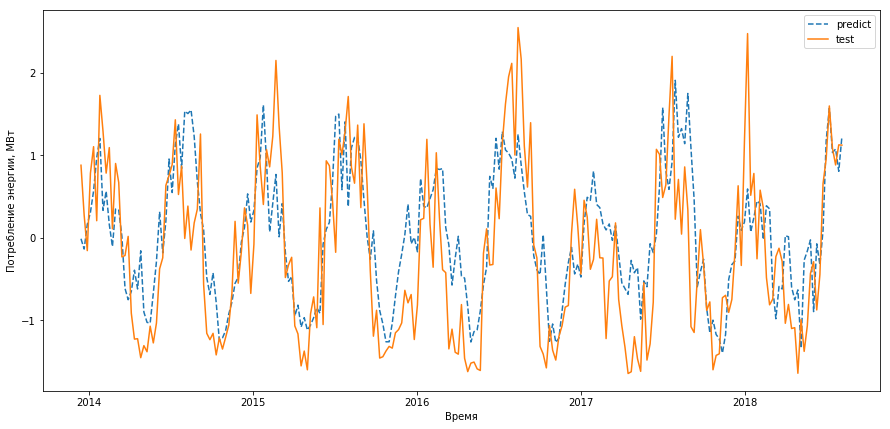

In [55]:
plt.figure(figsize=(15, 7))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h+p:], y_test_pred, linestyle='dashed', label='predict')
plt.plot(test.index[h+p:], y_test, label='test')
plt.legend()
plt.show()

In [56]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [57]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform(y_test),y_pred = scl_target.inverse_transform(y_test_pred))

In [58]:
print(f'Ошибка градиентного бустинга при h = {h} MAPE: {er_g:.2f}%')

Ошибка градиентного бустинга при h = 4 MAPE: 7.68%


#### -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.

In [59]:
h_1 = 1
p = 52
target_1 = data_w['PJME_MW'].values[h_1+p:].reshape(-1, 1)

In [60]:
y_1 = scl_target.fit_transform(target_1)
X_1 = data_w.iloc[p:-h_1, :].values
X_1 = scl_x.fit_transform(X_1.astype('float64'))

In [61]:
X_1.shape, y_1.shape

((813, 131), (813, 1))

In [62]:
f_test, _ = f_regression(X_1, y_1.ravel())

_Выбор 10 лучших признаков_

In [63]:
sfk_1 = SelectKBest(f_regression, k=10)

In [64]:
X_sfk_1 = sfk_1.fit_transform(X_1, y_1.ravel())

In [65]:
data_w.columns[sfk_1.get_support()]

Index(['PJME_MW', 'diff_log', 'diff_log_n', 'move_avr_4', 'history_51',
       'history_50', 'history_49', 'history_38', 'history_37', 'history_1'],
      dtype='object')

_Выбор 5% лучших признаков_

In [66]:
sfp_1 = SelectPercentile(f_regression, percentile=5)

In [67]:
X_sfp_1 = sfp_1.fit_transform(X_1, y_1.ravel())

In [68]:
data_w.columns[sfp_1.get_support()]

Index(['PJME_MW', 'diff_log', 'diff_log_n', 'move_avr_4', 'history_51',
       'history_50', 'history_1'],
      dtype='object')

_Выбор признаков через построение модели_

In [69]:
model_01 = GradientBoostingRegressor(random_state=21, max_depth=5, n_estimators=100)

In [70]:
model_01.fit(X_1, y_1.ravel())

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=21, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [71]:
sfm_1 = SelectFromModel(model_01, max_features=10)

In [72]:
sfm_1.fit(X_1, y_1.ravel())

SelectFromModel(estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...te=21, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
        max_features=10, norm_order=1, prefit=False, threshold=None)

In [73]:
X_sfm_1 = sfm_1.fit_transform(X_1, y_1.ravel())

In [74]:
data_w.columns[sfm_1.get_support()]

Index(['PJME_MW', 'diff_log', 'diff_log_n', 'history_51', 'history_49',
       'history_36', 'history_25', 'history_22', 'history_11'],
      dtype='object')

__Набор лучших признаков__

In [75]:
best_params_1 = list(set(list(np.where(sfk_1.get_support())[0]) + list(np.where(sfp_1.get_support())[0]) + list(np.where(sfm_1.get_support())[0])))
best_params_1

[0, 67, 40, 41, 42, 77, 53, 22, 23, 24, 56, 27, 28, 29]

При h = 4 было [32, 69, 70, 5, 42, 43, 44, 55, 24, 57, 56, 28, 29, 30, 31]

In [76]:
X_best_1 = X_1[:, best_params_1]

__Разделение на test/train__

_Дата та же, что и при h = 4_

In [77]:
print(data_w.index[-300])

2012-11-11 00:00:00


In [78]:
train_1, test_1 = split_data(data_w, data_w.index[-300])

In [79]:
X_train_1 = X_best_1[:train_1.shape[0], :]
y_train_1 = y_1[:train_1.shape[0], 0]
X_test_1 = X_best_1[train_1.shape[0]:, :]
y_test_1 = y_1[train_1.shape[0]:, 0]

__Моделирование с h = 1__

In [80]:
model_h_1 = GradientBoostingRegressor(max_depth=5, random_state=21, n_estimators=100)

In [81]:
model_h_1.fit(X_train_1, y_train_1)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=21, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [82]:
y_test_pred_1 = model_h_1.predict(X_test_1)

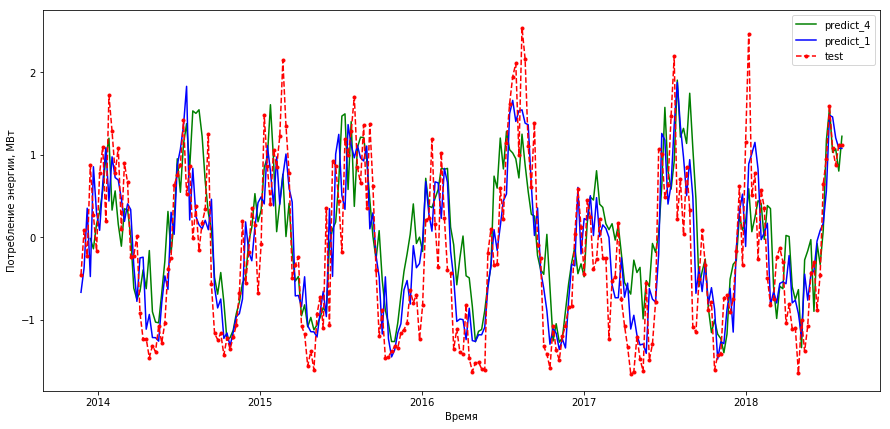

In [83]:
plt.figure( figsize=(15, 7))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h+p:], y_test_pred, 'g', label='predict_4')
plt.plot(test_1.index[h_1+p:], y_test_pred_1, 'b', label='predict_1')
plt.plot(test_1.index[h_1+p:], y_test_1, '.r', linestyle='dashed', label='test')
plt.legend()
plt.show()

In [84]:
er_g_1 = mean_absolute_percentage_error(y_true=scl_target.inverse_transform(y_test_1),y_pred = scl_target.inverse_transform(y_test_pred_1))

In [85]:
print(f'Ошибка градиентного бустинга при h = {h_1} MAPE: {er_g_1:.2f}%')

Ошибка градиентного бустинга при h = 1 MAPE: 6.15%


#### -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

4. Примените авторегрессию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек. 

In [86]:
best_columns_1 = data_w.columns[best_params_1]

column_list = list(data_w.columns)
num_diff_log = column_list.index('diff_log')
num_diff_log_n = column_list.index('diff_log_n')
num_move_avr_4 = column_list.index('move_avr_4')
length = X_test_1.shape[0]

best_columns_1

Index(['PJME_MW', 'history_11', 'history_38', 'history_37', 'history_36',
       'history_1', 'history_25', 'diff_log', 'diff_log_n', 'move_avr_4',
       'history_22', 'history_51', 'history_50', 'history_49'],
      dtype='object')

In [87]:
def prediction(N, X_predict, y_predict, p=52, model=model_h_1):
    
#['PJME_MW', 'history_11', 'history_38', 'history_37', 'history_36', 'history_1', 'history_25', 'diff_log', 
#     0            1            2             3             4              5          6             7
#'diff_log_n', 'move_avr_4', 'history_22', 'history_51', 'history_50', 'history_49']
#     8             9             10            11            12            13
    
    for i in range(N):

        y_predict[i] = model.predict(X_predict[i,:].reshape((1,-1)))

        # восстановление немасштабированного значения ряда в текущей точке  
        y_i = scl_target.inverse_transform(y_predict[i:i+1])

        # заполнение вектора для прогноза следующей точки
        X_predict[i+1, 0] = (y_i - scl_x.mean_[0])/scl_x.scale_[0]

        # построение исторических признаков, в списке history_list "глубина" каждого исторического ряда
        history_list = [0, 11, 38, 37, 36, 1, 25, 0, 0, 0, 22, 51, 50, 49]
        number_list = [1, 2, 3, 4, 5, 6, 10, 11, 12, 13]

        for n in number_list:
            X_predict[i+1, n] = X_predict[-history_list[n]-(i+1), 0]

        # построение 'diff_log', признака под номером 7

        X_predict[i+1, 7] = (np.log(y_i) - scl_x.mean_[num_diff_log])/scl_x.scale_[num_diff_log]

        # построение 'diff_log_n', признака под номером 8

        X_predict[i+1, 8] = (np.log(y_i)/d_log_max - scl_x.mean_[num_diff_log_n])/scl_x.scale_[num_diff_log_n]

        # построение 'move_avr_4', признака под номером 9

        if i+1 <= 4:
            start_ = 0
        else:
            start_ = i + 1 - 4

        X_predict[i+1, 9] = np.mean(X_predict[start_:i+1, 0])
        
    return X_predict, y_predict

In [88]:
X_predict = X_test_1.copy()
y_predict = y_test_pred_1.copy()
N = 4

X_pred, y_pred = prediction(N, X_predict, y_predict, p = 52, model=model_h_1)

In [89]:
er_g_2 = mean_absolute_percentage_error(y_true=scl_target.inverse_transform(y_test_1[:N]),y_pred = scl_target.inverse_transform(y_pred[:N]))
print(f'Ошибка градиентного бустинга MAPE: {er_g_2:.2f}%')

Ошибка градиентного бустинга MAPE: 3.87%


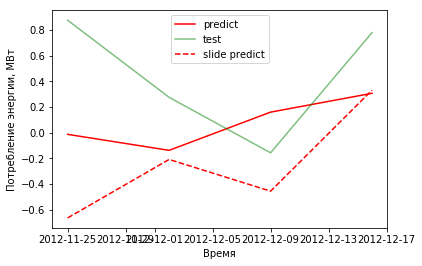

In [90]:
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:N+1],y_test_pred[:N], 'r',label='predict' )
plt.plot(test.index[1:N+1],y_test[:N], 'g',label='test', alpha=0.5)
plt.plot(test.index[1:N+1],y_pred[:N], '--r',label='slide predict')

plt.legend()
plt.show()    

In [91]:
q = 0
p = 4
d = 0
pdq = [p, d, q]

In [92]:
model = ARIMA(data_w['PJME_MW'].values[:-4], order=pdq)
results = model.fit(disp=False)

Сравниваются прогнозы модели AR (прямое моделирование) и модели рекурсивного моделирования

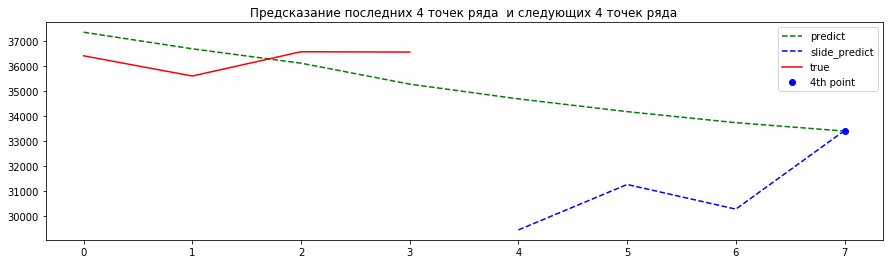

In [93]:
pred_dynamic = results.forecast(8)    
slide_predict = y_pred[:N]*scl_x.scale_[0] + scl_x.mean_[0]

plt.figure(figsize=(15, 4))
plt.plot(pred_dynamic[0], '--g', label='predict')
plt.plot(np.arange(4)+N, slide_predict, '--b', label='slide_predict')
plt.plot(data_w['PJME_MW'].values[-4:],'r', label='true')
plt.plot(7, slide_predict[3], 'ob', linewidth = 25, label='4th point')
plt.title('Предсказание последних 4 точек ряда  и следующих 4 точек ряда')
plt.legend()

plt.show()

In [94]:
er_g_AR = mean_absolute_percentage_error(y_true=data_w['PJME_MW'].values[-4:], y_pred=pred_dynamic[0][0:4])
print(f'Ошибка авторегрессионной модели MAPE: {er_g_AR:.2f}%, \nОшибка модели градиентного бустинга при h = {h} MAPE: {er_g_2:.2f}%')

Ошибка авторегрессионной модели MAPE: 2.60%, 
Ошибка модели градиентного бустинга при h = 4 MAPE: 3.87%


In [95]:
print(f'Предсказанное значение в 4-й точке:' 
      f'\nпутем прямого моделирования = {pred_dynamic[0][7]:.1f},'
      f'\nпутем рекурсивного моделирования = {slide_predict[3]:.1f},'
      f'\nотносительная разница значений в 4-ой точке составляет = {np.abs(pred_dynamic[0][7] - slide_predict[3])/slide_predict[3] * 100:.2f}%')      

Предсказанное значение в 4-й точке:
путем прямого моделирования = 33411.0,
путем рекурсивного моделирования = 33430.2,
относительная разница значений в 4-ой точке составляет = 0.06%


#### -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10*i-й до (i+1)*10 -й,... ,от 90 до 100-й точках (используйте осреденение по десяткам точек)

Т.к. модель градиентного бустинга научена на train-данных, то test-данные она "не знает".  
Поэтому, чтобы было от чего считать ошибку, посчитаем скользящий прогноз на 100 точек от точки начала test-данных и сравним прогноз с test.

In [96]:
N = 100
X_pred_100, y_pred_100 = prediction(N, X_predict, y_predict, p = 52, model=model_h_1)

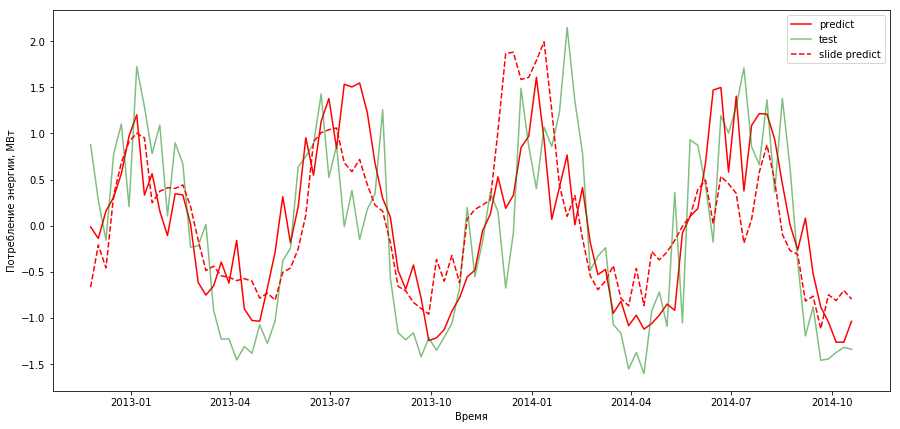

In [97]:
plt.figure(figsize=(15, 7))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:N+1], y_test_pred[:N], 'r', label='predict')
plt.plot(test.index[1:N+1], y_test[:N], 'g', label='test', alpha=0.5)
plt.plot(test.index[1:N+1], y_pred[:N], '--r', label='slide predict')

plt.legend()
plt.show()    

In [98]:
num = [i for i in range(0, 101, 10)]
error_list = []

for i in range(len(num)-1):

    err_i = mean_absolute_percentage_error(y_true=scl_target.inverse_transform(y_test[num[i]:num[i+1]]),y_pred = scl_target.inverse_transform(y_pred[num[i]:num[i+1]]))
    error_list.append(err_i)

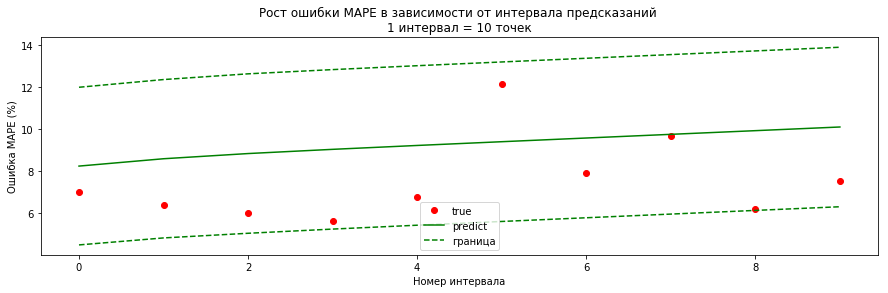

In [99]:
nn = len(error_list)    

model = ARIMA(error_list, order=(2, 1, 1))
model_fit = model.fit(disp=False)

plt.figure(figsize=(15, 4))
y_f = model_fit.forecast(nn)
plt.plot(error_list,'or', label ='true')
plt.plot(np.arange(nn), y_f[0],'g', label ='predict')
plt.plot(np.arange(nn),y_f[2][:,1],'--g', label = 'граница')
plt.plot(np.arange(nn),y_f[2][:,0],'--g')
plt.xlabel('Номер интервала')
plt.ylabel('Ошибка MAPE (%)')
plt.title('Рост ошибки MAPE в зависимости от интервала предсказаний \n1 интервал = 10 точек')
plt.legend()
plt.show()

#### -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

Как видно из последнего графика, ошибка линейно растёт с ростом горизонта планирования

In [100]:
error_growth = (y_f[0][9] - y_f[0][0])/100 
print(f'В среднем ошибка прогнозирования при h = 100 растёт на каждой точке на {error_growth:.2f} %')

В среднем ошибка прогнозирования при h = 100 растёт на каждой точке на 0.02 %
